In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import importlib
import dataReading 
from scipy.optimize import minimize, fsolve
from functools import partial
from scipy.stats import norm, t
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm
import seaborn as sns

In [15]:
# # How to load all functions from a file into the notebook
# importlib.reload(dataReading) # Needed so that you dont need to reload kernel when changing function
# from dataReading import *

## 1. Explore the weekly data set (market_data.csv) 
- a) Plot the evolution of the stocks and the interest rates over the period 1996-01-01 -> 2023-12-31, in 
two separate plots (with legends). Normalize all the stock prices so that they have an initial price of 100 
enabling a fair comparison of their performances. Do not normalize the rates. 
- b) Determine for each stock (and present in a table):  
• the annualized mean log-return,   
• the annualized volatility of log-returns,  
• the 5th and the 95th log-return percentiles, and 
• the minimum and maximum log-return.  
- c) Determine the correlation matrix for the log-returns of all stocks and interest rates and plot as a 
heatmap, together with the values formatted as percent. 


*Method:* 
- The stock prices were normalized to have initial price 100. Then their price charts were calculated using the log returns. Meanwhile the rates were plotted. 
- The mean log returns are calculated and multiplied by 52 to get annual return. The same thing was done for volatility but it was scaled by the square root of 52. The percentiles were calculated. 
- The correlation matrix was created for the collection of assets.

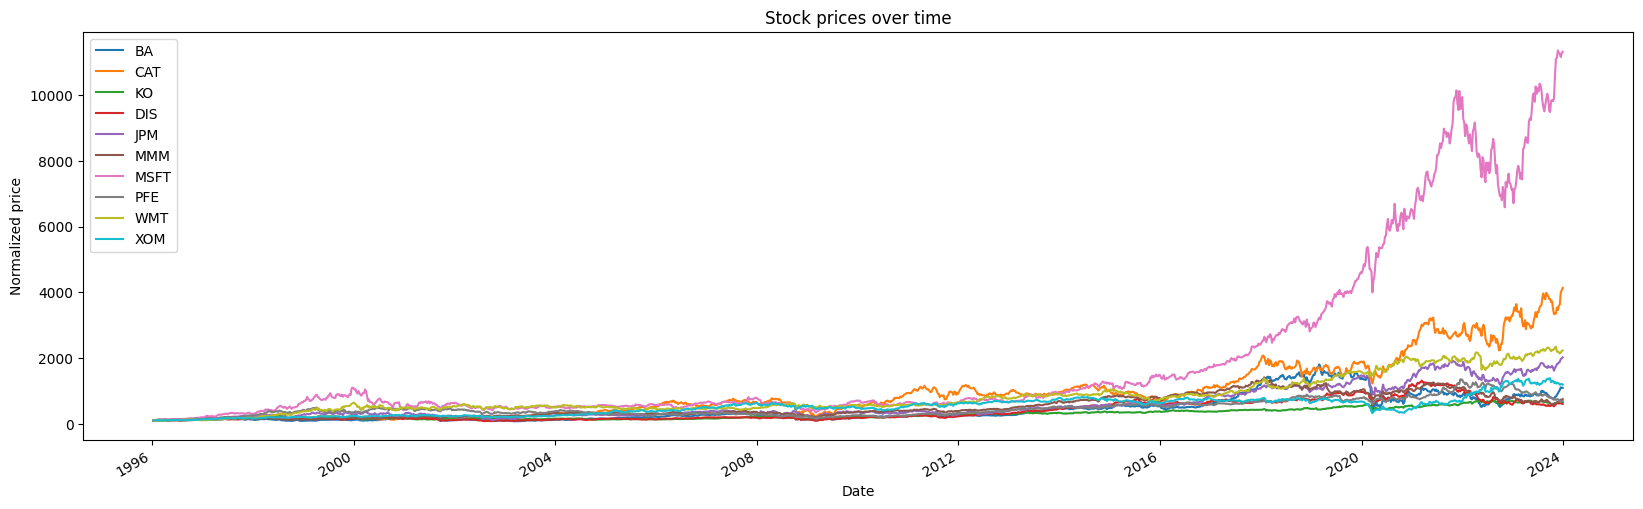

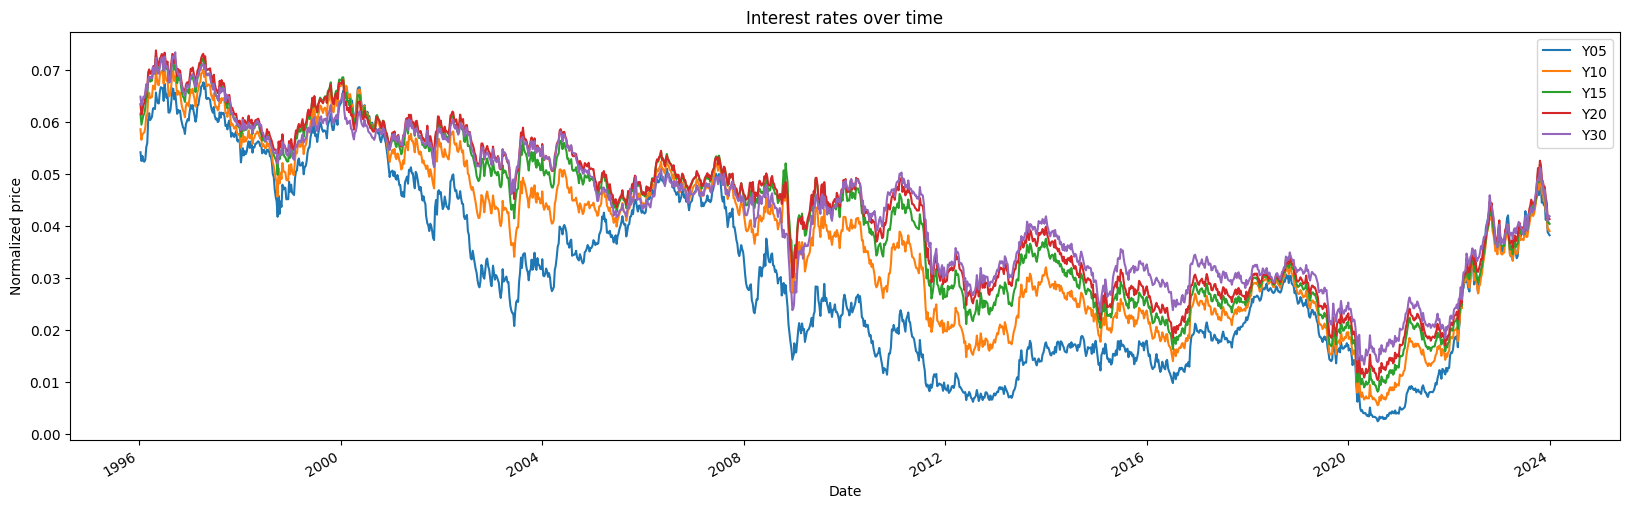

In [16]:
## a
marketDataDf = pd.read_csv('market_data.csv', sep=';', parse_dates=True, index_col='Date')
StockDF = marketDataDf.iloc[:,:10].copy()
RatesDF = marketDataDf.iloc[:,10:].copy()

factor = 100/ StockDF.iloc[0,:].values
factorMatrix = np.tile(factor,(StockDF.shape[0],1))
normalizedDf = pd.DataFrame(StockDF.values * factorMatrix, index= StockDF.index, columns=StockDF.columns)

AllAssetsNormalizedDf = pd.concat([normalizedDf,RatesDF], axis=1)

normalizedDf.plot(figsize=(20,6), title = 'Stock prices over time', ylabel='Normalized price');
RatesDF.plot(figsize=(20,6), title = 'Interest rates over time', ylabel='Normalized price');


In [17]:
## b
stockReturnDf = np.log(StockDF).diff()
stockReturnDf = stockReturnDf.dropna()

meanLogReturn = stockReturnDf.mean() * 52
volatilityLogReturns = stockReturnDf.std() * np.sqrt(52)
lowerPercentile = stockReturnDf.quantile(0.05)
upperPercentile = stockReturnDf.quantile(0.95)
minimum = stockReturnDf.min()
maximum = stockReturnDf.max()

TableDf = pd.DataFrame(columns=stockReturnDf.columns)
TableDf.loc['Mean Log Return'] = meanLogReturn
TableDf.loc['Volatility Log Returns'] = volatilityLogReturns
TableDf.loc['5th Percentile'] = lowerPercentile
TableDf.loc['95th Percentile'] = upperPercentile
TableDf.loc['Minimum'] = minimum
TableDf.loc['Maximum'] = maximum


TableDf

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM
Mean Log Return,0.085129,0.132540,0.067044,0.063968,0.107058,0.071682,0.168428,0.069638,0.110565,0.088146
Volatility Log Returns,0.380066,0.327965,0.223867,0.282605,0.359231,0.234068,0.286411,0.256015,0.242611,0.242465
5th Percentile,-0.072979,-0.072514,-0.045274,-0.060455,-0.075834,-0.054422,-0.058759,-0.051922,-0.051592,-0.052012
95th Percentile,0.072263,0.076259,0.047819,0.064185,0.071254,0.051068,0.068038,0.058124,0.053755,0.053587
Minimum,-0.582992,-0.224978,-0.236452,-0.248513,-0.416844,-0.174427,-0.211151,-0.227099,-0.216747,-0.223982
Maximum,0.533614,0.269244,0.111502,0.163325,0.399379,0.160226,0.209799,0.133070,0.167702,0.154747


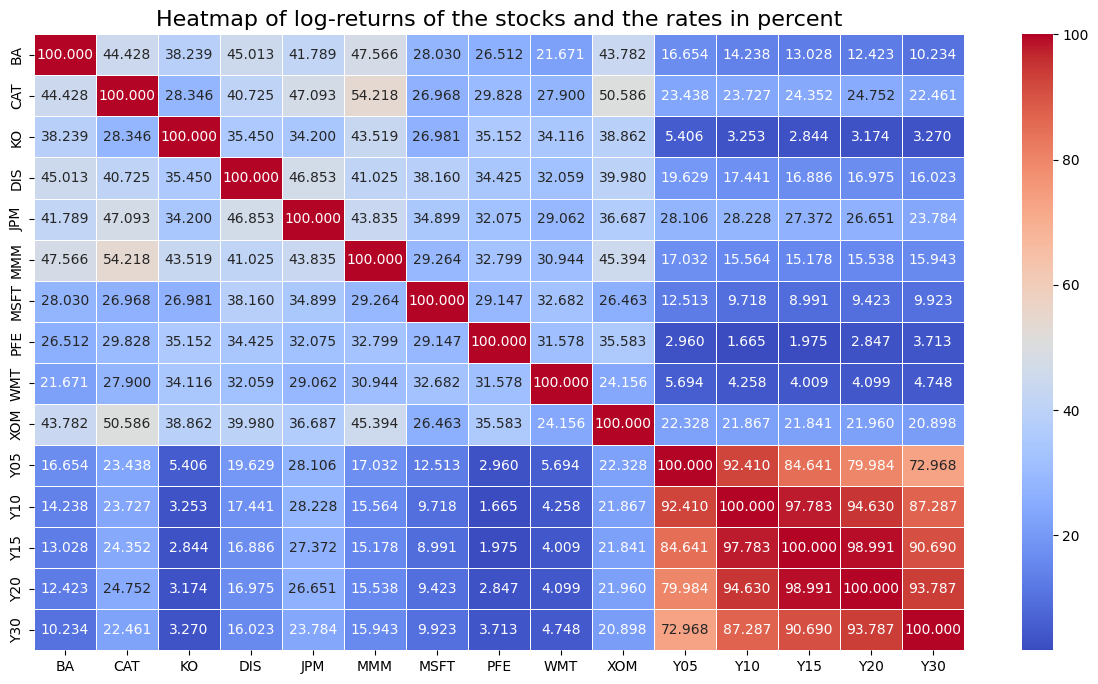

In [18]:
## c
AllAssetsLR= np.log(AllAssetsNormalizedDf).diff()
AllAssetsLR = AllAssetsLR.dropna()

corMat = AllAssetsLR.corr()*100
plt.figure(figsize=(15, 8))

sns.heatmap(corMat, annot=True, fmt=".3f",cmap='coolwarm', linewidths=0.5, linecolor='white');
plt.title('Heatmap of log-returns of the stocks and the rates in percent', fontsize=16);


## 2. VAR(1)-model 
Estimate a VAR(1)-model for the market. 
- a) Estimate the parameters (include them in the report) and check whether the model is stable or not 
(this check should also be detailed in the report). 
- b) Calculate the volatilities of the VAR-residuals and include them in the report. 
- c) Simulate 5000 scenarios with 480 weekly time steps for all assets and plot the price (or interest rate) 
percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and Walmart and the 5- and 
30-year interest rates. 
A total of four plots. Also list these percentiles, for the time periods 240 and 
480, in two tables with the percentiles in the horizontal direction and the stocks and interest rates in 
the vertical direction.

*Method:*
- The VAR(1) model was fitted and the largest absolute eigenvalue of the A1 matrix was found to see if the model is stable. 
- The volatility of each stocks residuals was calculated. 
- The VAR(1)-model was simulated 5000 times for 480 weeks for all assets to get the log-returns. The log-returns were used to calculate the price paths. The percentiles of the simulations were then calculated. 

In [19]:
# a)
AllAssetsDf = marketDataDf
AllAssetsLR= np.log(AllAssetsDf).diff()
AllAssetsLR = AllAssetsLR.dropna()

oneVec = np.ones((AllAssetsLR.shape[0],1))
M = np.concatenate((oneVec, AllAssetsLR.values), axis=1)[:-1,]
Y = AllAssetsLR.values[1:,:]

a = np.linalg.inv(M.T @ M) @ M.T @ Y

A1 = a[1:,:]
A0 = a[0,:]

e,v = np.linalg.eig(A1)

LargestAbsEigenvalue = max(abs(e))

stableTest = LargestAbsEigenvalue < 1
print(f'The largest absolute eigenvalue is: {LargestAbsEigenvalue}')
print(f'Is the model stable? : {stableTest} ')

The largest absolute eigenvalue is: 0.25210972133871695
Is the model stable? : True 


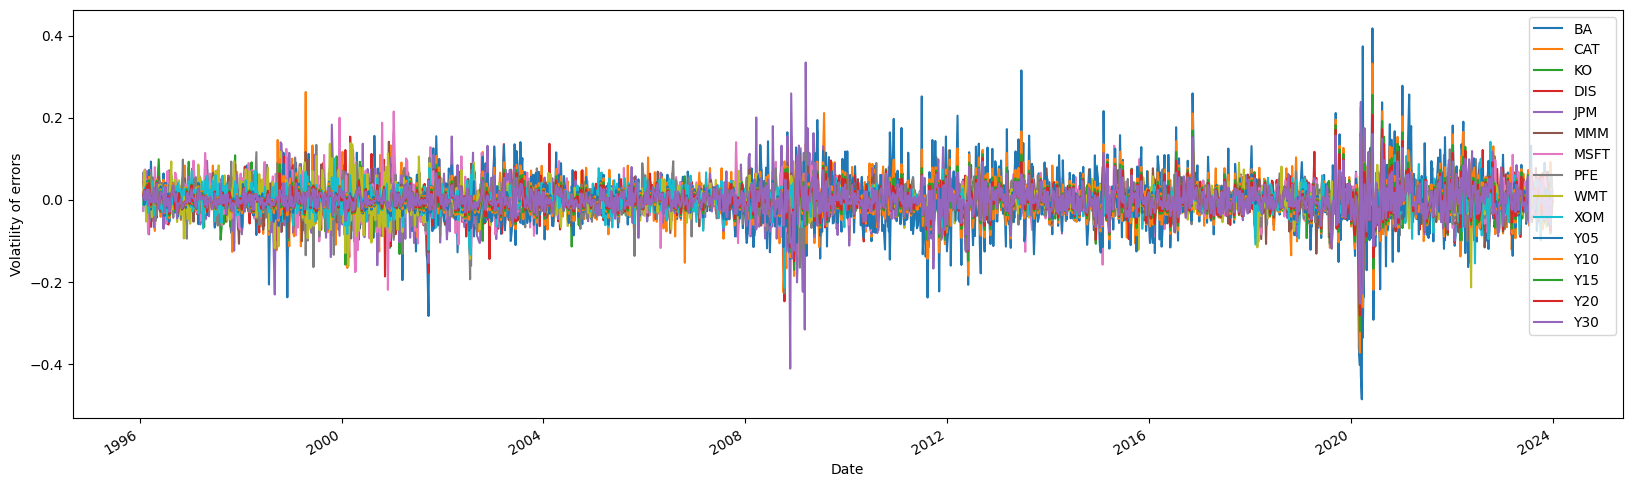

In [20]:
# b)

error = Y - M@a
errorVolatility = np.std(error, axis=0)

PlotVolatilityDF = pd.DataFrame(columns=AllAssetsLR.columns, data=error, index=AllAssetsLR.index[1:])
PlotVolatilityDF.plot(figsize=(20,6), ylabel='Volatility of errors');

In [21]:
VolDF = pd.DataFrame(columns=AllAssetsLR.columns)
VolDF.loc['Weekly Volatility'] = errorVolatility
VolDF

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
Weekly Volatility,0.051474,0.045248,0.030478,0.038889,0.048894,0.031861,0.039394,0.035126,0.032749,0.032972,0.06117,0.045801,0.038763,0.035077,0.033758


In [22]:
def VAR1Simulator(Y0, epsilon, A0, A1):
  simulations = epsilon.shape[0]
  numberOfStocks = epsilon.shape[1]
  timeSteps = epsilon.shape[2]

  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  Y = np.zeros((simulations, numberOfStocks, timeSteps ))
  Y[0, :, 0] = Y0
  for i in range(simulations):
    for t in range(1, timeSteps ):
          Y[i, :, t] = A0 + A1.T @ Y[i, :, t-1] + epsilon[i, :, t]
  return Y

In [23]:
# c)
simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)

covMat = AllAssetsLR.cov()

choleskyMatrix = np.linalg.cholesky(covMat)

# Generate random number cube where depth is simulations, height is stocks, width is time steps
Z = np.random.standard_normal((simulations, numberOfStocks,  weeklyTimestep))
X = choleskyMatrix@Z

Y0 = AllAssetsLR.iloc[-1:].values

simulatedLR = VAR1Simulator(Y0, X, A0, A1)


In [24]:
sumLogReturns = np.cumsum(simulatedLR, axis=2)
initialPrice = AllAssetsDf.iloc[-1,].values
initialPriceMatrix = np.tile(initialPrice, (5000, 480, 1)).transpose(0, 2, 1)
#simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, 1:])

simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, :])


quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

catepillarPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentile[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        walmartPercentile[i, j] = np.quantile(simulatedPrices[:, 8, i], quantileValues[j])
        fiveYearPercentile[i, j] = np.quantile(simulatedPrices[:, 10, i], quantileValues[j])
        thirtyYearPercentile[i, j] = np.quantile(simulatedPrices[:, 14, i], quantileValues[j])

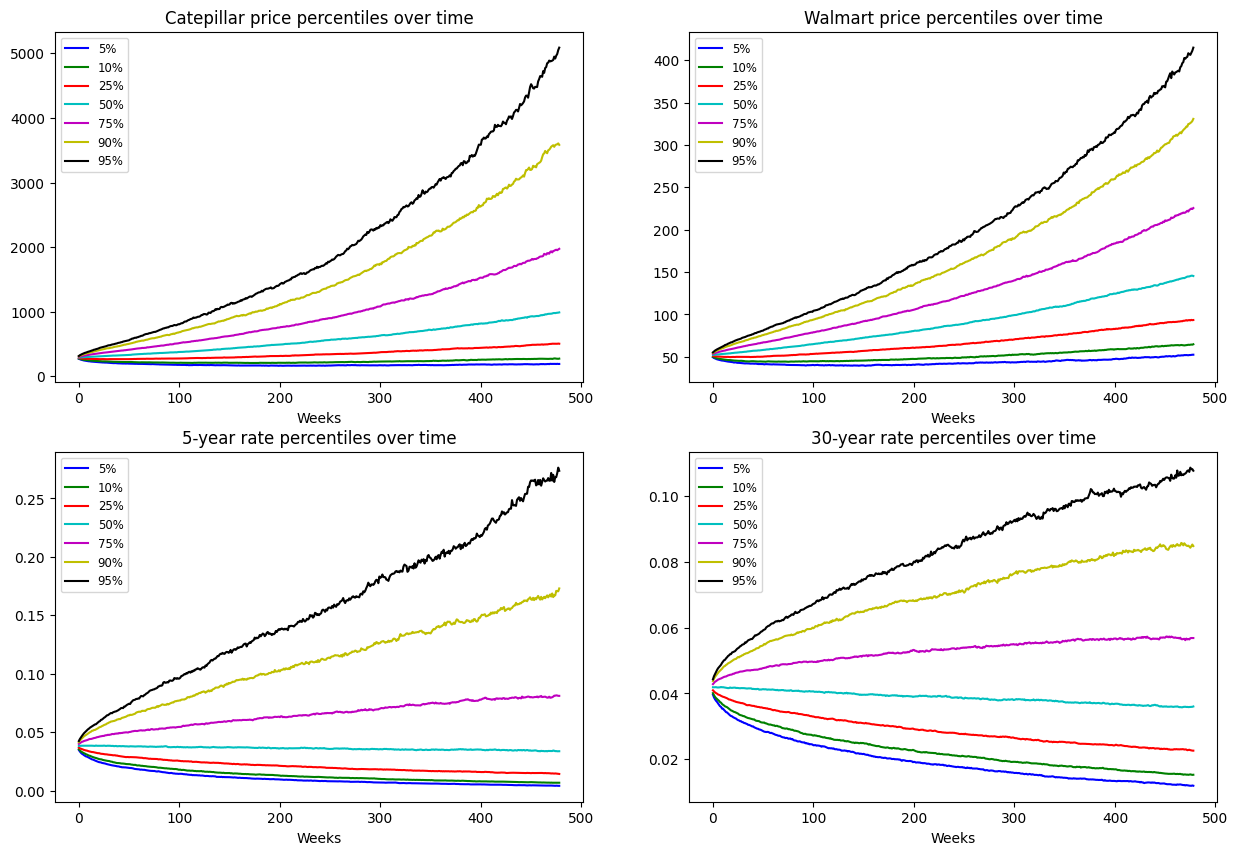

In [25]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label, color = color)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize = 'small')
ax[0,0].set_xlabel('Weeks')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label, color = color)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize = 'small')
ax[0,1].set_xlabel('Weeks')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label, color = color)

ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize = 'small')
ax[1,0].set_xlabel('Weeks')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label, color = color)

ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize = 'small')
ax[1,1].set_xlabel('Weeks')

plt.show()

In [26]:
fullTableDf = pd.DataFrame(columns=percentiles)
fullTableDf.loc['Catepillar'] = catepillarPercentile[479,:]
fullTableDf.loc['Walmart'] = walmartPercentile[479,:]
fullTableDf.loc['5-year rate'] = fiveYearPercentile[479,:]
fullTableDf.loc['30-year rate'] = thirtyYearPercentile[479,:]

title = "                           Price and Rate Percentiles for 480 weeks"

print(title)
fullTableDf

                           Price and Rate Percentiles for 480 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,192.333819,274.809742,505.446077,990.302820,1974.536036,3584.056183,5089.057676
Walmart,52.403219,64.721568,93.336404,145.324741,225.553197,330.828232,414.975501
5-year rate,0.004024,0.006647,0.014186,0.033635,0.081032,0.172997,0.273721
30-year rate,0.011992,0.015321,0.022640,0.036052,0.056830,0.084753,0.107621


In [27]:
halfTableDf = pd.DataFrame(columns=percentiles)
halfTableDf.loc['Catepillar'] = catepillarPercentile[239,:]
halfTableDf.loc['Walmart'] = walmartPercentile[239,:]
halfTableDf.loc['5-year rate'] = fiveYearPercentile[239,:]
halfTableDf.loc['30-year rate'] = thirtyYearPercentile[239,:]

title = "                           Price and Rate Percentiles for 240 weeks"

print(title)
halfTableDf

                           Price and Rate Percentiles for 240 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,166.466544,214.182331,339.576368,543.816956,864.073248,1307.150336,1680.246035
Walmart,41.750359,48.305605,64.098954,86.914741,117.910985,153.687773,182.326307
5-year rate,0.008197,0.011683,0.019911,0.036049,0.065822,0.111665,0.150978
30-year rate,0.017866,0.021200,0.028101,0.038702,0.053697,0.070345,0.084128


## 3. Historical simulation 
Use basic historical simulation to simulate 5000 scenarios with 480 weekly time steps for all assets and plot 
the price (or interest rate) percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and 
Walmart and the 5- and 30-year interest rates. A total of four plots. Also list these percentiles, for the time 
periods 240 and 480, in two tables with the percentiles in the horizontal direction and the stocks and interest 
rates in the vertical direction. Plot the percentiles (as dotted lines) in the same plot as the VAR(1)-percentiles. 

*Method:*
- The historical data was used to sample log returns for 5000 scenarios of 480 weeks for all assets with replacement. The percentiles of the simulated prices were then calculated on the price paths calculated from the log returns. 

In [28]:
sims = 5000
weeks = 480
indexList = [1,8,10,14]

simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)


StocksOfInterest = AllAssetsLR.iloc[1:,indexList]

arrays = []

for _ in range(weeks):
    sampled_df = StocksOfInterest.sample(n=sims, replace=True).to_numpy()
    arrays.append(sampled_df)


arrays_3d = np.transpose(np.array(arrays), (1,2,0))

quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]


sumLogReturns = np.cumsum(arrays_3d, axis=2)
initialPrice = AllAssetsDf.iloc[-1,[1,8,10,14]].values
initialPriceMatrix = np.tile(initialPrice, (5000, 480, 1)).transpose(0, 2, 1)
simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, :])



catepillarPercentileHS = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentileHS = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentileHS = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentileHS = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentileHS[i, j] = np.quantile(simulatedPrices[:, 0, i], quantileValues[j])
        walmartPercentileHS[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        fiveYearPercentileHS[i, j] = np.quantile(simulatedPrices[:, 2, i], quantileValues[j])
        thirtyYearPercentileHS[i, j] = np.quantile(simulatedPrices[:, 3, i], quantileValues[j])



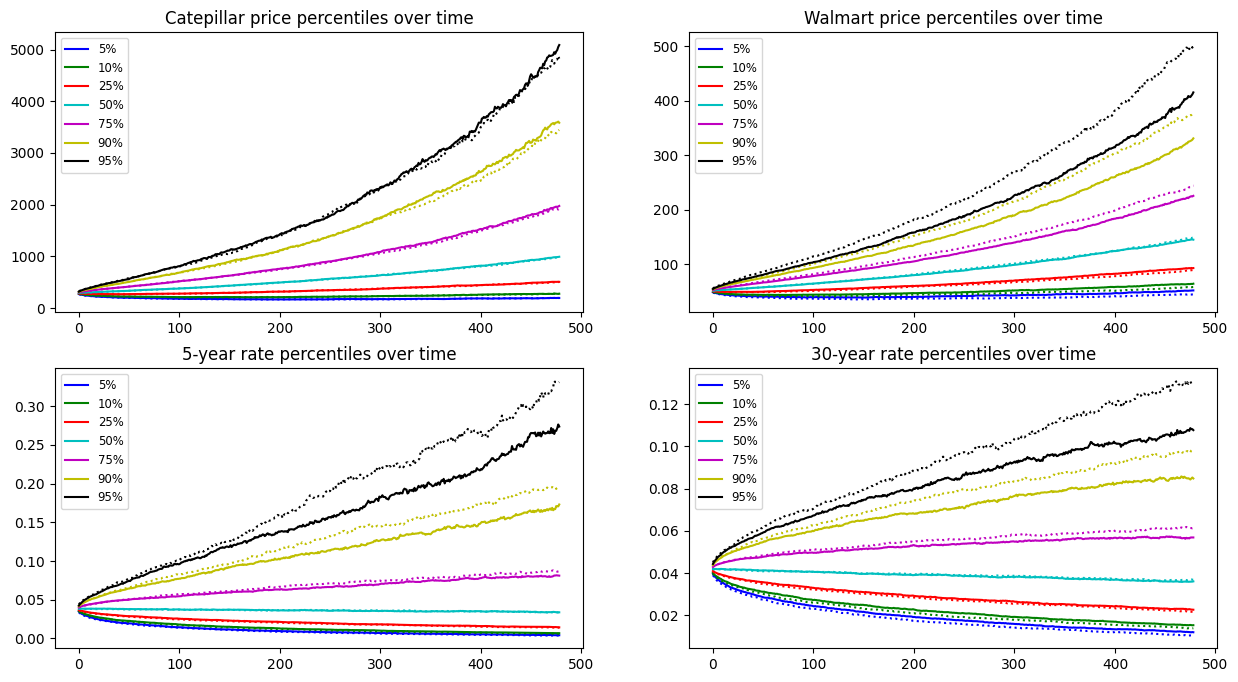

In [29]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label, color = color)
    ax[0, 0].plot(catepillarPercentileHS[1:, i], linestyle = 'dotted', color = color)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize = 'small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label, color = color)
    ax[0, 1].plot(walmartPercentileHS[1:, i], linestyle = 'dotted', color = color)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize = 'small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label, color = color)
    ax[1, 0].plot(fiveYearPercentileHS[1:, i], linestyle = 'dotted', color = color)


ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize = 'small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label, color = color)
    ax[1, 1].plot(thirtyYearPercentileHS[1:, i], linestyle = 'dotted', color = color)


ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize = 'small')

plt.show()

In [30]:
fullTableDf = pd.DataFrame(columns=percentiles)
fullTableDf.loc['Catepillar'] = catepillarPercentileHS[479,:]
fullTableDf.loc['Walmart'] = walmartPercentileHS[479,:]
fullTableDf.loc['5-year rate'] = fiveYearPercentileHS[479,:]
fullTableDf.loc['30-year rate'] = thirtyYearPercentileHS[479,:]

title = "                           Price and Rate Percentiles for 480 weeks"

print(title)
fullTableDf

                           Price and Rate Percentiles for 480 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,196.670496,274.895424,502.431063,983.427632,1928.344886,3445.573668,4826.472194
Walmart,44.705887,58.690268,89.944503,149.370427,244.108028,378.053253,501.738159
5-year rate,0.003640,0.005929,0.013823,0.033714,0.086151,0.194719,0.331154
30-year rate,0.010451,0.013889,0.021615,0.036859,0.061284,0.098765,0.130117


In [31]:
halfTableDf = pd.DataFrame(columns=percentiles)
halfTableDf.loc['Catepillar'] = catepillarPercentileHS[239,:]
halfTableDf.loc['Walmart'] = walmartPercentileHS[239,:]
halfTableDf.loc['5-year rate'] = fiveYearPercentileHS[239,:]
halfTableDf.loc['30-year rate'] = thirtyYearPercentileHS[239,:]

title = "                           Price and Rate Percentiles for 240 weeks"

print(title)
halfTableDf

                           Price and Rate Percentiles for 240 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,165.124036,214.377295,343.378784,539.118065,848.783714,1325.744674,1680.812575
Walmart,37.755929,45.372359,62.023625,88.759559,126.676463,172.007167,209.734540
5-year rate,0.007695,0.010560,0.018932,0.036397,0.070077,0.127683,0.183495
30-year rate,0.016006,0.019424,0.027197,0.039138,0.055982,0.078345,0.094833


## 4. VAR(1)-DCC-model 
Estimate a VAR(1)-DCC-model for the market 
- a) Plot the ACF, for lags 1 to 50, for the (weekly) residuals and square residuals of the VAR-model, for 
Caterpillar and the 5-year interest rate.  
- b) Estimate the DCC-model and include the DCC-parameters in the report: delta, gamma, the R-matrix 
and the GARCH(1,1)-parameters as a 15*3-matrix. 
- c) Do 2.c) again and plot the price (or interest rate) percentiles (as dashed lines) in the same plot as the 
VAR(1)- and HS-percentiles 

*Method:*
- Using the ACF function, built in the last lab, on the residuals from the VAR(1)-model the ACF-plots were created.
- First we fit one GARCH-model to each assets residuals. Then we estimated the volatility of the residuals over time. Then the devolatized residuals were calculated. The log-likelihood function was constructed and maximized for delta and gamma using scipy. Using both the VAR(1)-model and the GARCH-model we simulated predictions of the log-returns. These were then converted into return series from which the precentiles over time were calculated and plotted.


*Discussion:* What does a) tell you?  

- The square residuals from the VAR(1)-model appear to have some autocorrelation, this means that we can improve our predictions of the log-returns by utilizing the information in the squared residuals. This can be done by using the GARCH-model. There does not appear to be any autocorrelation between the residuals.



In [32]:
def AutoCorrelationFunction(data, lags, plot = True):
    returnValues = np.zeros(lags)

    for i in range(1,lags+1):
        original = data[0:-(1+i)]
        lagged = data[i:-1]
        meanValue = np.mean(original)
        variance = np.var(original)
        
        returnValues[i-1] = (1/len(original) * ((original - meanValue) @ (lagged - meanValue).T) )/variance
    
    return returnValues

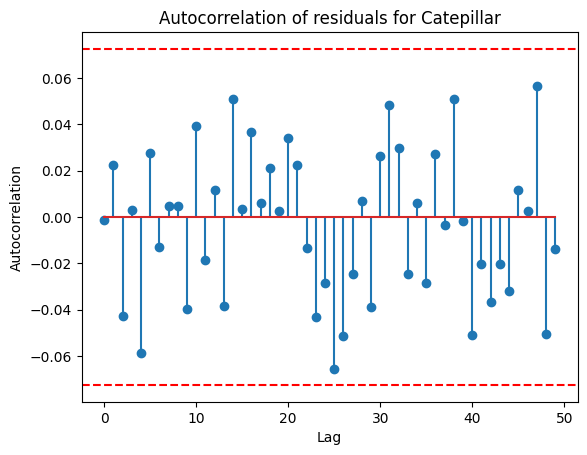

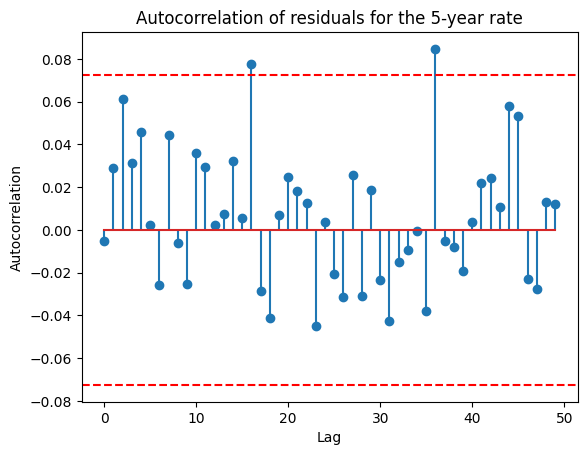

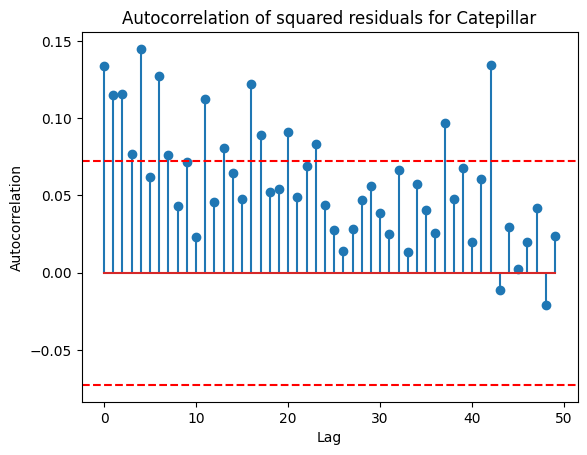

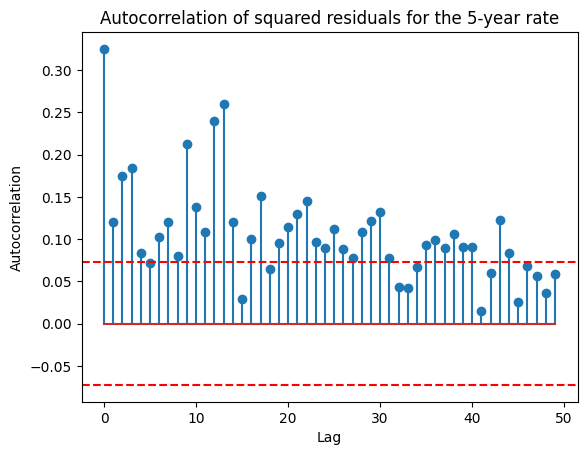

In [33]:
lags = 50

squaredError = error ** 2

ACFCatepillarResiduals = AutoCorrelationFunction(error[:,1], lags)
ACFfiveYearResiduals = AutoCorrelationFunction(error[:,10], lags)

ACFCatepillarSquareResiduals = AutoCorrelationFunction(squaredError[:,1], lags)
ACFfiveYearSsquareResiduals = AutoCorrelationFunction(squaredError[:,10], lags)

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(error[:,1]))
fig, ax = plt.subplots()
ax.stem(ACFCatepillarResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of residuals for Catepillar')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(error[:,10]))
fig, ax = plt.subplots()
ax.stem(ACFfiveYearResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of residuals for the 5-year rate')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(squaredError[:,1]))
fig, ax = plt.subplots()
ax.stem(ACFCatepillarSquareResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of squared residuals for Catepillar')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(squaredError[:,10]))
fig, ax = plt.subplots()
ax.stem(ACFfiveYearSsquareResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of squared residuals for the 5-year rate')
plt.show()


In [34]:
def likelihoodFunction( parameters, dataFrame):
    omega = parameters[0]
    alpha = parameters[1]
    beta = parameters[2]
    initialVolatility = np.std(dataFrame['multipliedResiduals']) 

    volatilityVector = np.zeros(len(dataFrame))
    volatilityVector[0] = initialVolatility
    terms = np.zeros(len(dataFrame)-1)

    for i in range(1, len(dataFrame)):
        volatilityVector[i] = np.sqrt(omega + alpha * float(dataFrame.iloc[i-1]['multipliedResiduals']**2)  + beta * volatilityVector[i-1] ** 2)
        terms[i-1] = np.log(volatilityVector[i] ** 2) + float(dataFrame.iloc[i]['multipliedResiduals']**2) / (volatilityVector[i] ** 2)
        
    likelihood = -1/2 * (sum(terms))
    return -likelihood


def optimizeGarchParameters(data):
    epsilon = 1e-10
    constraints = [{'type': 'ineq', 'fun': lambda parameters: -(parameters[1] +parameters[2] -1 -epsilon)}]
    bounds = [(0 + epsilon, None), (0 + epsilon, None), (0 + epsilon, None)] #omega, alpha, beta

    x0 = [0.005, 0.12, 0.83]
    objectiveFixDF = partial(likelihoodFunction, dataFrame = data)
    result = minimize(objectiveFixDF, x0, method='SLSQP', bounds=bounds, constraints=constraints )
    return result


def GARCHVolatilityEstimator(dataFrame, omega, alpha, beta, initialVolatility):
    volatilityEstimateGARCH = np.zeros(dataFrame.shape[0])
    volatilityEstimateGARCH[0] = initialVolatility 

    for i in range(1, len(volatilityEstimateGARCH)):  # Start from 1 to avoid reassigning the first value
        volatilityEstimateGARCH[i] = np.sqrt(omega + alpha * dataFrame.iloc[i-1]['squarePrice'] + beta * (initialVolatility ** 2))
        initialVolatility = volatilityEstimateGARCH[i]

    return volatilityEstimateGARCH


In [35]:
## Create a dataframe 
errorDF = pd.DataFrame(data = error, index = AllAssetsLR.index[1:] , columns=AllAssetsLR.columns)
resMat = np.zeros((15,3))

# ## Optimizing GARCH parameters
for i in range(len(errorDF.columns)):    
    df = errorDF.iloc[:,[i]].copy()
    df['multipliedResiduals'] = (100 * df.iloc[:,[0]] )
    result = optimizeGarchParameters(df)
    resMat[i,:] = result.x

resMat[:,0] = resMat[:,0]/(100**2) 

c:\Users\emill\OneDrive\Umu\4\RiskManagement\Python\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\emill\OneDrive\Umu\4\RiskManagement\Python\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\emill\OneDrive\Umu\4\RiskManagement\Python\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\emill\OneDrive\Umu\4\RiskManagement\Python\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\emill\OneDrive\Umu\4\RiskManagement\Python\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: Run

In [36]:
def likelihoodFunctionDCC( parameters, R, Z_t):
    delta = parameters[0]
    gamma = parameters[1]

    T = Z_t.shape[0]
    K = Z_t.shape[1]

    Q = R # Q1
    funcVal = 0

    for i in range(1,T):
        Z_lagged = np.array(Z_t[i-1,:][:,np.newaxis], dtype=np.float64)
        Q = (1 - delta - gamma) * R + delta * Z_lagged @ Z_lagged.T + gamma * Q

        Q_tilde_inv = np.linalg.inv(np.diag((np.diag(Q) ** 0.5)))
        R_t = Q_tilde_inv @ Q @ Q_tilde_inv

        Z_now =  np.array(Z_t[i,:][:,np.newaxis], dtype=np.float64)
        funcVal += (np.log( 1/ ((2*np.pi) ** (K /2) * np.sqrt(np.linalg.det(R_t)))) - 1/2 * Z_now.T @ np.linalg.inv(R_t) @ Z_now)[0,0]
    return -funcVal

In [37]:
## Calculate volatility estimates for all assets over time

volatilityDF = pd.DataFrame(index= errorDF.index , columns=errorDF.columns)

for i in range(len(errorDF.columns)):    
    df = errorDF.iloc[:,[i]].copy()
    df['squarePrice'] = df.iloc[:,[0]] ** 2
    initialVolatility = np.std(df.iloc[:,0])

    volatilityDF.iloc[:,i] = GARCHVolatilityEstimator(df, resMat[i,0], resMat[i,1], resMat[i,2],initialVolatility)


In [84]:
## Calculate Zt matrix and R
Z_tDF = (errorDF / volatilityDF )
R = Z_tDF.corr().values

Z_t = Z_tDF.values

# Maximize parameters delta and gamma using log likelihood

epsilon = 1e-10
constraints = [{'type': 'ineq', 'fun': lambda parameters: -(parameters[0] + parameters[1] -1 -epsilon )}]
bounds = [(0 + epsilon, None), (0 + epsilon, None)] #delta gamma

x0 = [0.003, 0.95]
objectiveFixDF = partial(likelihoodFunctionDCC, Z_t = Z_t, R = R )
result = minimize(objectiveFixDF, x0, bounds=bounds, constraints=constraints )

delta, gamma = result.x




In [103]:
RDf = pd.DataFrame(R, index=AllAssetsLR.columns, columns=AllAssetsLR.columns)
print('                                                                     The R matrix')
RDf

                                                                     The R matrix


,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
BA,1.000000,0.454793,0.347553,0.414103,0.411919,0.448720,0.278901,0.278603,0.262515,0.401220,0.189721,0.162991,0.147159,0.144212,0.147950
CAT,0.454793,1.000000,0.262795,0.397856,0.488456,0.525828,0.299210,0.287848,0.287531,0.501389,0.272923,0.267762,0.265529,0.269525,0.260284
KO,0.347553,0.262795,1.000000,0.357050,0.327575,0.410951,0.307154,0.369642,0.361418,0.376868,0.049138,0.025422,0.019352,0.026284,0.032928
DIS,0.414103,0.397856,0.357050,1.000000,0.482989,0.411356,0.381332,0.346771,0.313537,0.391386,0.221265,0.192990,0.179544,0.181131,0.190421
JPM,0.411919,0.488456,0.327575,0.482989,1.000000,0.447327,0.350488,0.347224,0.310993,0.398285,0.297384,0.288638,0.278410,0.270538,0.250762
MMM,0.448720,0.525828,0.410951,0.411356,0.447327,1.000000,0.319695,0.338989,0.317286,0.440565,0.186629,0.171800,0.163071,0.164762,0.169943
MSFT,0.278901,0.299210,0.307154,0.381332,0.350488,0.319695,1.000000,0.293647,0.323009,0.271691,0.170138,0.139210,0.128514,0.133453,0.139548
PFE,0.278603,0.287848,0.369642,0.346771,0.347224,0.338989,0.293647,1.000000,0.320072,0.358420,0.064037,0.047607,0.051789,0.065235,0.074320
WMT,0.262515,0.287531,0.361418,0.313537,0.310993,0.317286,0.323009,0.320072,1.000000,0.259533,0.103607,0.082217,0.078640,0.085319,0.096384
XOM,0.401220,0.501389,0.376868,0.391386,0.398285,0.440565,0.271691,0.358420,0.259533,1.000000,0.227645,0.210477,0.203145,0.206266,0.220960


In [86]:
print('Delta:', delta)
print('Gamma', gamma)

Delta: 0.01780930935775202
Gamma 0.9630388224252255


In [105]:
print('       GARCH(1,1) parameters')
GARCHparametersDf = pd.DataFrame(resMat, index=AllAssetsLR.columns, columns = ['omega', 'alpha', 'beta'])
GARCHparametersDf

       GARCH(1,1) parameters


,omega,alpha,beta
BA,0.000065,0.099505,0.878016
CAT,0.000059,0.060560,0.910549
KO,0.000023,0.084601,0.892252
DIS,0.000047,0.091974,0.878262
JPM,0.000051,0.111592,0.865911
MMM,0.000025,0.065202,0.911439
MSFT,0.000033,0.064640,0.913460
PFE,0.000014,0.031582,0.957377
WMT,0.000020,0.046594,0.933823
XOM,0.000045,0.118721,0.845384


In [39]:
def Q_Updater(delta, gamma, R, Z, Q_last):
    Q_new = (1- delta - gamma)*R + delta* Z @ Z.T + gamma* Q_last
    return Q_new

def R_calculator(Q):
    R_new = np.linalg.inv( np.sqrt(np.diag(np.diag(Q))))  @ Q  @ np.linalg.inv( np.sqrt(np.diag(np.diag(Q))))  
    return R_new

def VolatilityMatrixUpdater(GarchParameterMat ,Epsilon_last, D_last):
    D_vec= np.zeros(len(Epsilon_last))
    for i in range(len(Epsilon_last)):
        D_vec[i] = np.sqrt(GarchParameterMat[i,0] + GarchParameterMat[i,1] * Epsilon_last[i] ** 2 + GarchParameterMat[i,2] * D_last[i,i] ** 2)

    D_new = np.diag(D_vec)
    return D_new

def C_t_calculator(R,D):
    Sigma = D @ R @ D.T
    C = np.linalg.cholesky(Sigma)
    return C

In [40]:
def VAR1DCCSimulator(Y0, D_0, Epsilon_0, Z, A0, A1, delta, gamma, GarchParameterMat, R ):
  simulations = Z.shape[0]
  numberOfStocks = Z.shape[1]
  timeSteps = Z.shape[2]

  Q_t = R
  D_t = D_0
  Epsilon_last = Epsilon_0
  Z_last = np.linalg.inv(D_t) @ Epsilon_last
  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  Y = np.zeros((simulations, numberOfStocks, timeSteps ))
  Y[0, :, 0] = Y0
  for i in range(simulations):
    for t in range(1, timeSteps ):
          
          R_t = R_calculator(Q_t)
          Q_t = Q_Updater(delta,gamma,R,Z_last, Q_t)
          D_t = VolatilityMatrixUpdater(GarchParameterMat, Epsilon_last, D_t)
          C = C_t_calculator(R_t, D_t)
          Y[i, :, t] = A0 + A1.T @ Y[i, :, t-1] + C @ Z[i, :, t]
          Epsilon_last = C @ Z[i, :, t]
          Z_last = np.linalg.inv(D_t) @ Epsilon_last

  return Y

In [41]:
# c)
simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)

covMat = AllAssetsLR.cov()

choleskyMatrix = np.linalg.cholesky(covMat)

# Generate random number cube where depth is simulations, height is stocks, width is time steps
Z = np.random.standard_normal((simulations, numberOfStocks,  weeklyTimestep))
Y0 = AllAssetsLR.iloc[-1:].values

D_0 = np.diag(np.array(volatilityDF.iloc[-1,:].values, dtype=np.float64))
Epsilon_0 = errorDF.iloc[-1,:].values
simulatedLrDCC = VAR1DCCSimulator(Y0, D_0,Epsilon_0, Z, A0, A1, delta, gamma, resMat, R)

In [42]:
sumLogReturns = np.cumsum(simulatedLrDCC, axis=2)
initialPrice = AllAssetsDf.iloc[-1,].values
initialPriceMatrix = np.tile(initialPrice, (5000, 480, 1)).transpose(0, 2, 1)

simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, :])

quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

catepillarPercentileDCC = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentileDCC = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentileDCC = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentileDCC = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentileDCC[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        walmartPercentileDCC[i, j] = np.quantile(simulatedPrices[:, 8, i], quantileValues[j])
        fiveYearPercentileDCC[i, j] = np.quantile(simulatedPrices[:, 10, i], quantileValues[j])
        thirtyYearPercentileDCC[i, j] = np.quantile(simulatedPrices[:, 14, i], quantileValues[j])

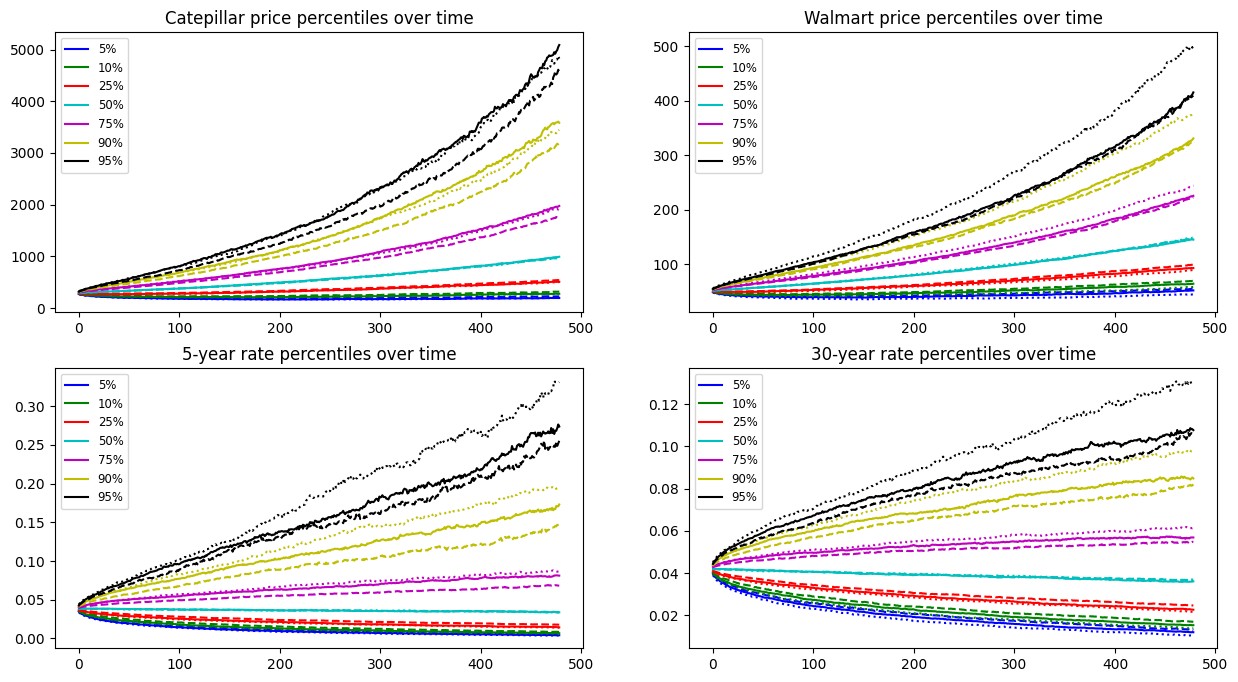

In [43]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label, color=color)
    ax[0, 0].plot(catepillarPercentileHS[1:, i], linestyle='dotted', color=color)
    ax[0, 0].plot(catepillarPercentileDCC[1:, i], linestyle='dashed', color=color)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize='small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label, color=color)
    ax[0, 1].plot(walmartPercentileHS[1:, i], linestyle='dotted', color=color)
    ax[0, 1].plot(walmartPercentileDCC[1:, i], linestyle='dashed', color=color)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize='small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label, color=color)
    ax[1, 0].plot(fiveYearPercentileHS[1:, i], linestyle='dotted', color=color)
    ax[1, 0].plot(fiveYearPercentileDCC[1:, i], linestyle='dashed', color=color)

ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize='small')

for i, (label, color) in enumerate(zip(percentiles, colors)):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label, color=color)
    ax[1, 1].plot(thirtyYearPercentileHS[1:, i], linestyle='dotted', color=color)
    ax[1, 1].plot(thirtyYearPercentileDCC[1:, i], linestyle='dashed', color=color)

ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize='small')

plt.show()


## 5. Explore the data 
You can do this part of the assignment in Excel (in that case submit also the Excel file).  
- a) Plot the average, over the five years of data, of the mean population for each age for both men and 
women in the same figure. 
- b) Plot the average, over the five years of data, of the number of deaths for each age for both men and 
women in the same figure.   

*Method:* 
- The average of five years of the data was plotted for the mean population and the deaths for both men and women.

Discussion: What do these plots tell you? 

- These plots tells us that there are fewer young womenk but from 70 years old the men are fewer. Looking at the average deaaths we can see that the women are expected to live longer.

In [44]:
menDeathsDF = pd.read_excel('deathsMen.xlsx').dropna()
womenDeathsDF = pd.read_excel('deathsWomen.xlsx').dropna()
menPopulationDF = pd.read_excel('populationMen.xlsx').dropna()
womenPopulationDF = pd.read_excel('populationWomen.xlsx').dropna()

menDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
menDeathsDF.drop(columns='Unnamed: 1', inplace = True)
womenDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
womenDeathsDF.drop(columns='Unnamed: 1', inplace = True)

menPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
menPopulationDF.drop(columns='Unnamed: 1', inplace = True)
womenPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
womenPopulationDF.drop(columns='Unnamed: 1', inplace = True)



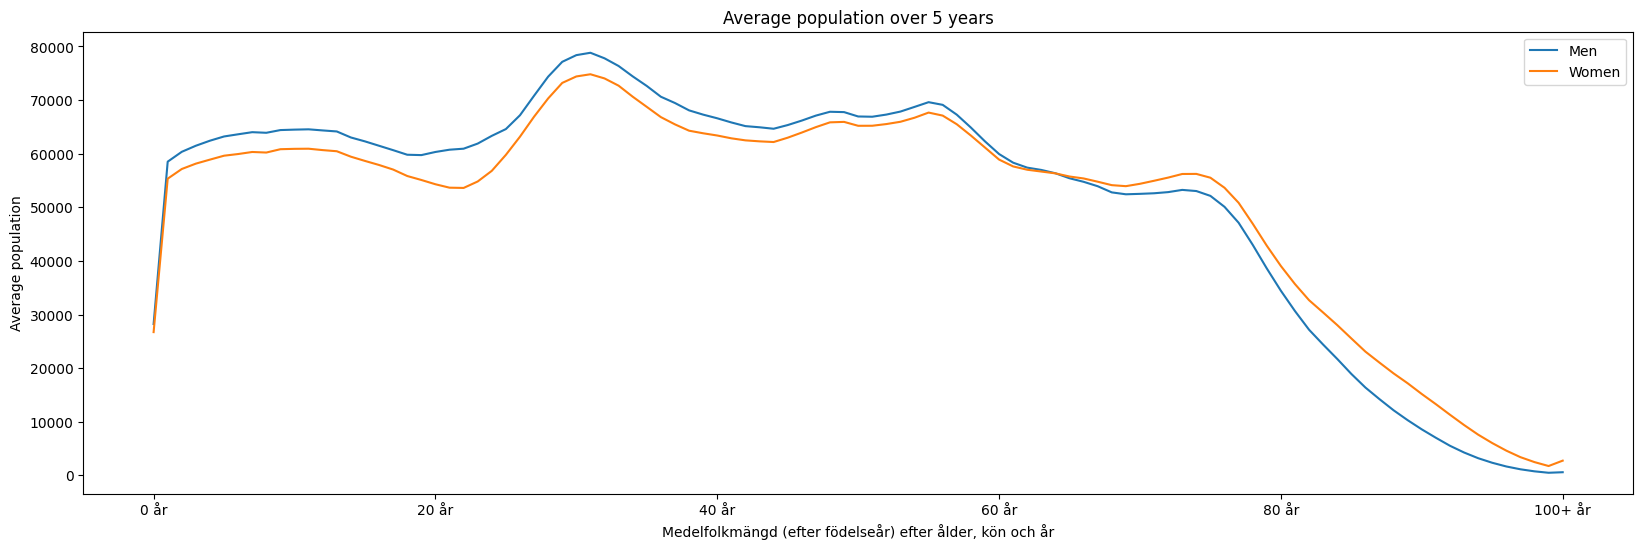

In [45]:
np.mean(menPopulationDF, axis=1).plot(figsize=(20,6),title='Average population over 5 years', ylabel='Average population', label='Men');
np.mean(womenPopulationDF, axis=1).plot(figsize=(20,6), ylabel='Average population', label='Women');
plt.legend();

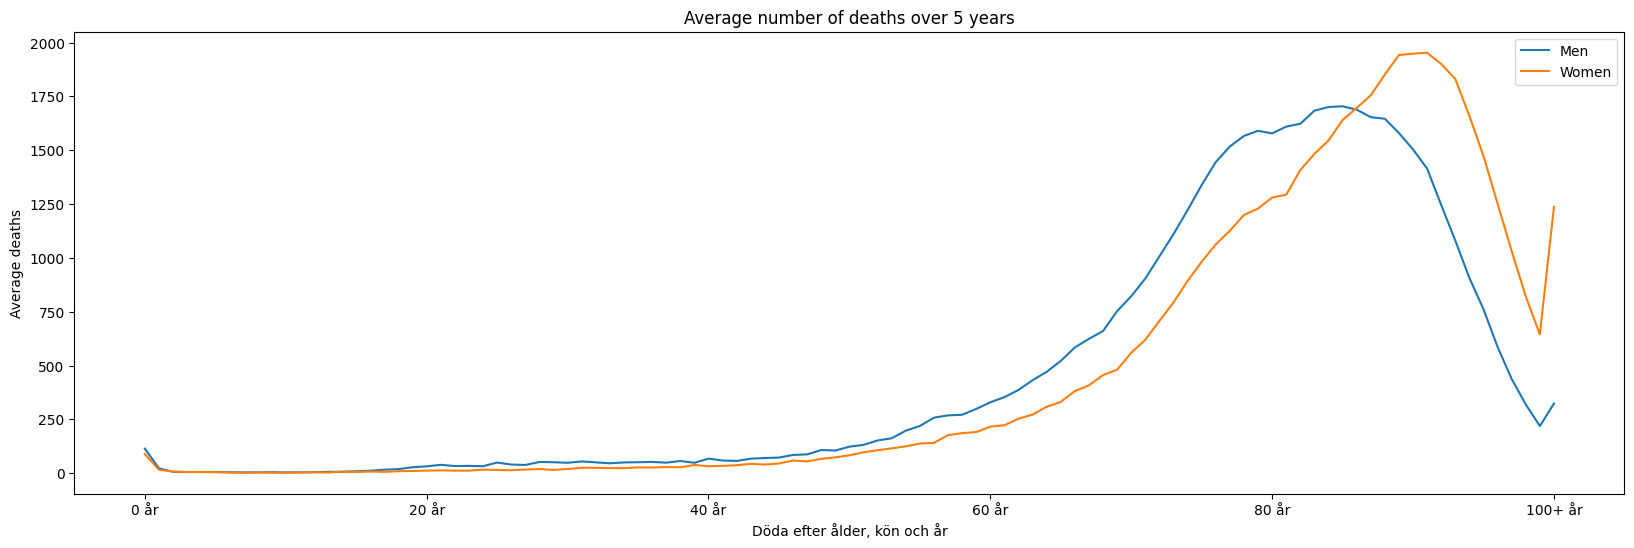

In [46]:
averageDeathsMen = np.mean(menDeathsDF, axis=1)
averageDeathsWomen = np.mean(womenDeathsDF, axis=1)
averageDeathsMen.plot(figsize=(20,6), title='Average number of deaths over 5 years', ylabel='Average deaths', label='Men');
averageDeathsWomen.plot(figsize=(20,6), ylabel='Average deaths', label='Women');
plt.legend();

## 6. Mortality estimation 
This task is also suitable for Excel, where you can use Solver to find the Makeham parameters. 
- a) Estimate the force of mortality for men and women separately using the SCB-data and plot these 
estimates in the same figure. Do this for ages 20 – 99 and use data for all five years for a more stable 
estimate. 
- b) Fit Makeham functions using only force of mortality estimates for ages 20 – 90 from above. Then plot 
the estimated forces of mortality, for ages 20 – 99, together with the Makeham functions in the same 
figure (both men and women). Include the parameters in the report. 
- c) Plot the survival functions for men and women, for ages 0 – 105, in the same figure (but not the same 
as in b).  
- d) Calculate life expectancy for both men and women, according to the lifetime distributions given by the 
Makeham functions. 

*Method*: 
- The data was plotted using the five year averages, and the the estimates was calculated using the Makeham parameters found.
- From the Makeham parameters the survival function was determined and then the survival functions was plotted together with the force of mortality.
- Then the life expectancy for both men and women was determined using the survival functions.

In [47]:
# a)
DMen = menDeathsDF.sum(axis=1)
DWomen = womenDeathsDF.sum(axis=1)

NMen = menPopulationDF.sum(axis=1)
NWomen = womenPopulationDF.sum(axis=1)

muMen = DMen/NMen
muWomen = DWomen/NWomen

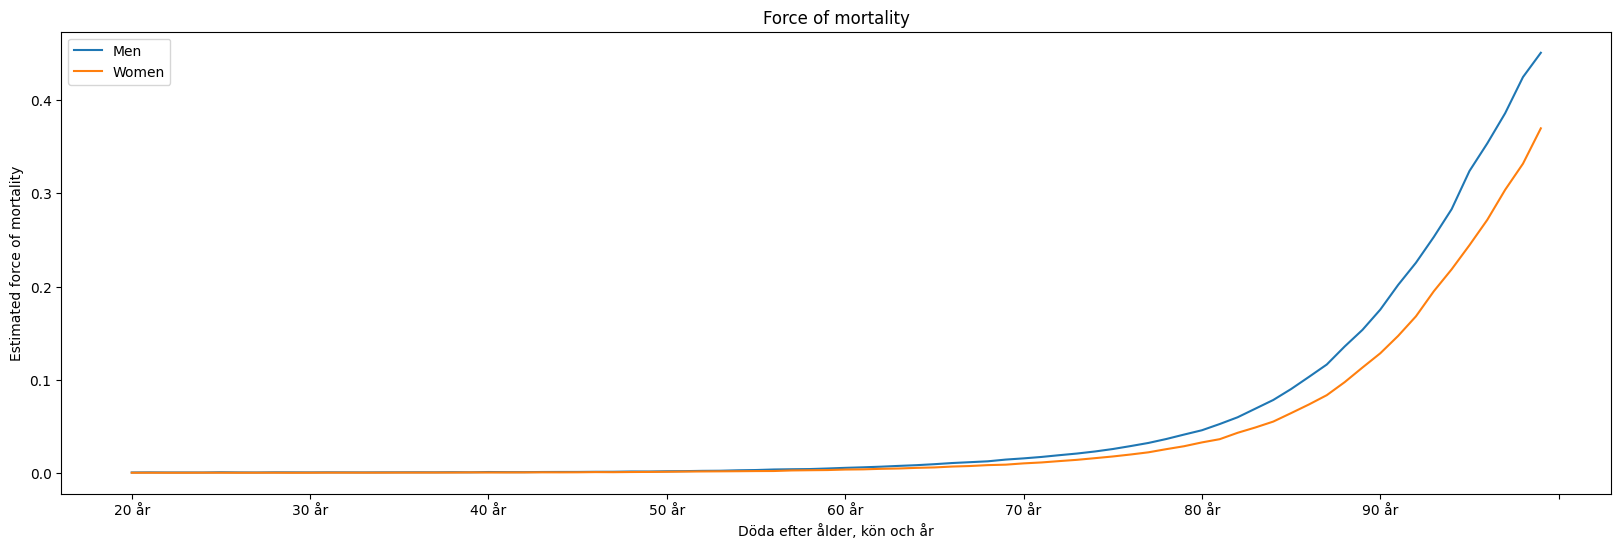

In [48]:
muMen.iloc[20:-1].plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen.iloc[20:-1].plot(figsize=(20,6), label='Women');
plt.legend();

In [49]:
def gammaFunction(gamma, mu, ages):

    f1 = np.sum(np.exp(gamma * ages))
    f2 = np.sum(np.exp(2 * gamma * ages))
    m = np.sum(mu)
    g = np.sum(mu * np.exp(gamma * ages))
    
    beta = (m * f1 - ages[-1] * g) / (f1**2 - ages[-1] * f2)
    alpha = (m * f2 - g * f1) / (ages[-1] * f2 - f1**2)
    
    eq = np.sum(alpha + beta * np.exp(gamma * ages) - mu)
    
    return eq

def alphaBetaFunction(gamma, mu, ages):

    f1 = np.sum(np.exp(gamma * ages))
    f2 = np.sum(np.exp(2 * gamma * ages))
    m = np.sum(mu)
    g = np.sum(mu * np.exp(gamma * ages))
    alpha = (m * f2 - g * f1) / (ages[-1] * f2 - f1**2)
    beta = (m * f1 - ages[-1] * g) / (f1**2 - ages[-1] * f2)

    return alpha, beta

def makehamFunction(alpha, beta, gamma, x):

    makeham = alpha+beta*np.exp(gamma*x)
    
    return makeham

In [50]:
gammaInitialGuess = 0.1
numberOfYears = np.arange(20, 90)
startYear = 20
endYear = 90
endYearPlot = 99

numberOfYearsPlot = np.arange(20, 99)

gammaMen = fsolve(lambda gamma:gammaFunction(gamma, muMen.iloc[startYear:endYear].values, numberOfYears), gammaInitialGuess)
alphaMen,betaMen = alphaBetaFunction(gammaMen, muMen.iloc[startYear:endYear].values, numberOfYears)
makehamMen = makehamFunction(alphaMen, betaMen, gammaMen, numberOfYearsPlot)

gammaWomen = fsolve(lambda gamma:gammaFunction(gamma, muWomen.iloc[startYear:endYear].values, numberOfYears), gammaInitialGuess)
alphaWomen,betaWomen = alphaBetaFunction(gammaWomen, muWomen.iloc[startYear:endYear].values, numberOfYears)
makehamWomen = makehamFunction(alphaWomen, betaWomen, gammaWomen, numberOfYearsPlot)


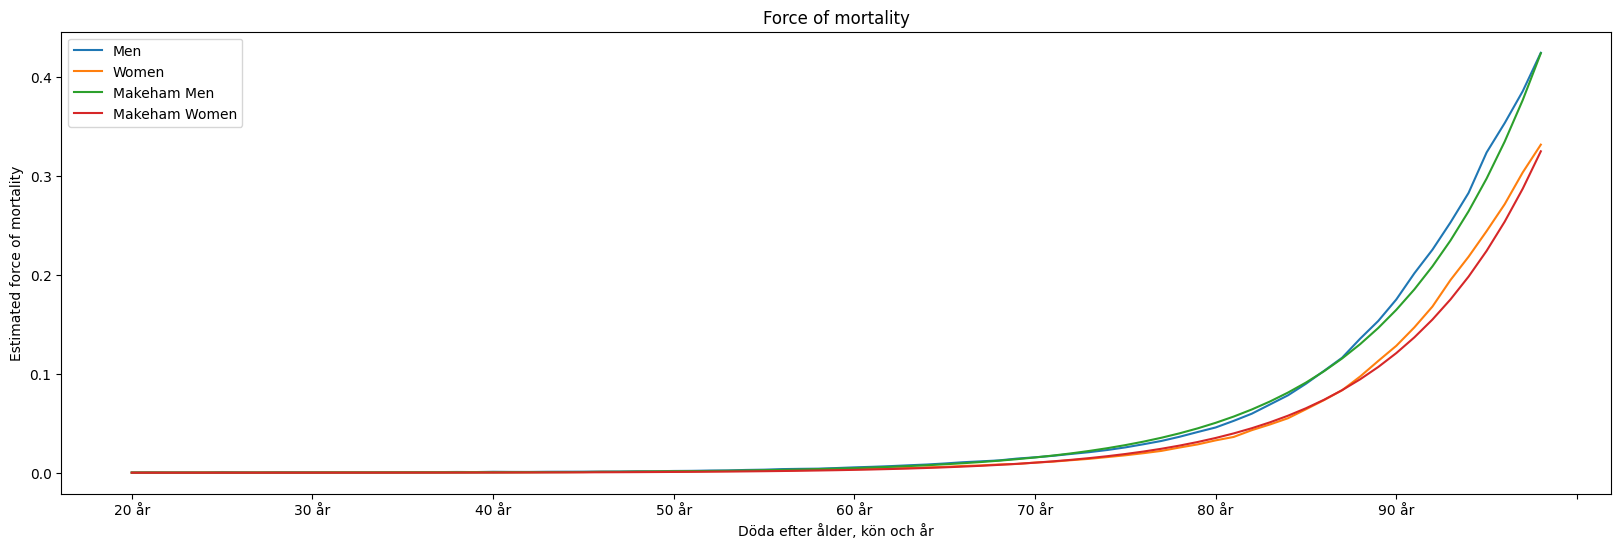

In [51]:


muMen.iloc[startYear:endYearPlot].plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen[startYear:endYearPlot].plot(figsize=(20,6), label='Women');
plt.plot(makehamMen, label = "Makeham Men")
plt.plot(makehamWomen, label = "Makeham Women")
plt.legend();

In [52]:
def survivalFunction(alpha, beta, gamma, x):
    l = np.exp( -alpha*x - (beta/gamma)*(np.exp(gamma*x)-1))
    return l


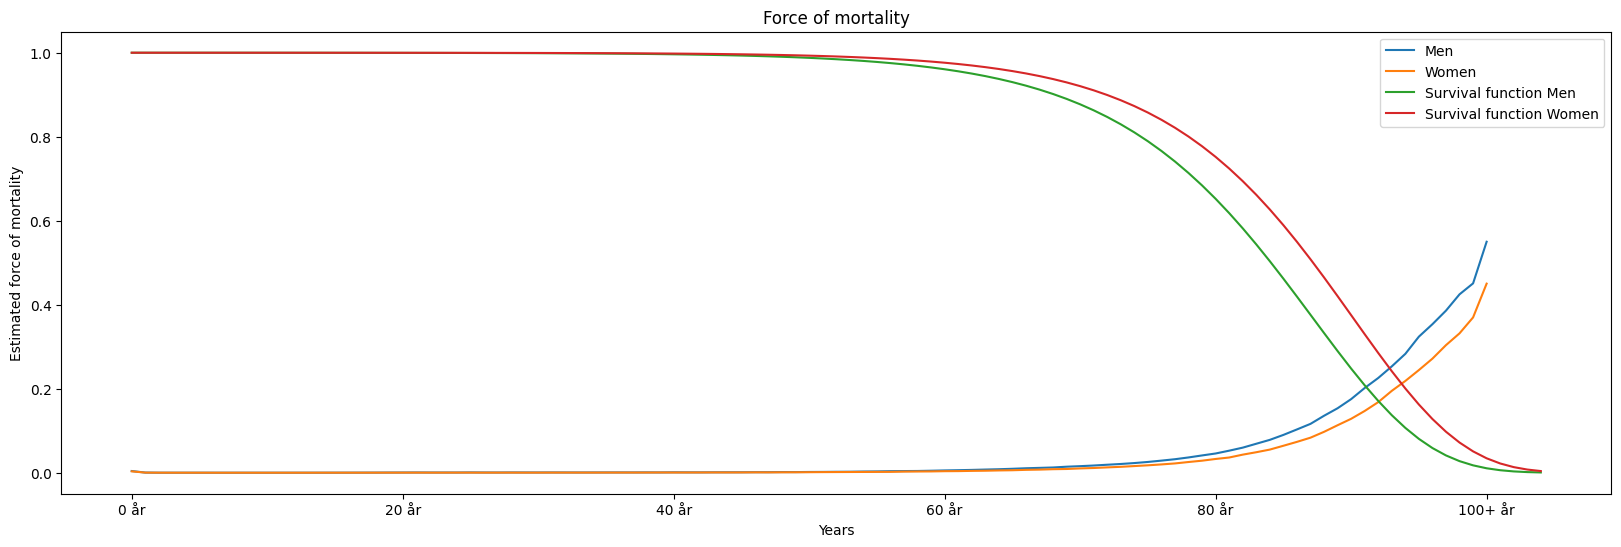

In [53]:
allYears = np.arange(0,105)
survivalMen = survivalFunction(alphaMen, betaMen, gammaMen, allYears)
survivalWomen = survivalFunction(alphaWomen, betaWomen, gammaWomen, allYears)

muMen.plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen.plot(figsize=(20,6), label='Women', xlabel='Years');
plt.plot(survivalMen, label = 'Survival function Men')
plt.plot(survivalWomen, label = 'Survival function Women')
plt.legend();

In [54]:
lifeExpectancyMen = np.sum(survivalMen)
lifeExpectancyWomen = np.sum(survivalWomen)


print('Life expectancy for men:', lifeExpectancyMen)
print('Life expectancy for women:', lifeExpectancyWomen)

Life expectancy for men: 82.80781867266559
Life expectancy for women: 85.98574881475402


## 7. 1st order payout and reserve 
Calculate the guaranteed payout amount and project the 1st order reserve for the policy.  
- a) Determine the yearly payout amount, b.  
- b) Plot the evolution of the reserve 30 years into the future.  
- c) Include a table with the value of the reserve for every 5 years.  

*Method*: 
- The yearly payout was determined through the reserve value at the initial time and using the expected premium amount and expected payout amount calculated at day 0.
- Then the evolution of the reserve was plotted using the expected reserve value obtained from the premium paying population and the pay out population.

In [55]:
def expectedPremium(alpha, beta, gamma, x, t, rateG):

    deltaG = np.log(1+rateG)
    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x))
    PV = lt/lx*np.exp(-deltaG*(t/12))

    return PV

def expectedPayout(alpha, beta, gamma, x, t, rateG):

    deltaG = np.log(1+rateG)
    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x))
    PV = lt/lx*np.exp(-deltaG*(t/12))

    return PV



In [56]:

# a)
rateG = 0.02
x = 60
z = 65
s = 120-z
u = z-x
t = 1
T = 12*(u+s)
b = 0
P = 120000
G = 2000000
payout = 0

for i in range(t, T):
    
    if(i<(12*u+1)):

        G = G + P/12*expectedPremium(alphaWomen, betaWomen, gammaWomen, x, i, rateG)
        
    else:
        payout = payout + expectedPayout(alphaWomen, betaWomen, gammaWomen, x, i, rateG)
        
b = 12*G/payout

print(f'Yearly payout: {b[0]}')


Yearly payout: 168141.2982883344


In [57]:
def qx(alpha, beta, gamma, x, t):

    lt = survivalFunction(alpha, beta, gamma, (x+(t)))
    lx = survivalFunction(alpha, beta, gamma, (x+((t-1))))
    qm = 1 - lt/lx

    return qm

def deadPopulation(pop_pp, pop_po, alpha, beta, gamma, x, t):
    
    t_pp_de = pop_pp*qx(alpha, beta, gamma, x, t)
    t_po_de = pop_po*qx(alpha, beta, gamma, x, t)

    return t_pp_de, t_po_de

def transferPopulation(pop_pp, t_pp_de, s):

    sm = 1-(1-s)**(1/12)
    t_pp_tr = (pop_pp-t_pp_de)*sm
    
    return t_pp_tr

def payoutTransfer(pop_pp, t_pp_de, t_pp_tr, t, u):

    if(t!=u):
        return 0
    
    return(pop_pp-t_pp_de-t_pp_tr)

def riskPremium(alpha, beta, gamma, x, G):

    lt = survivalFunction(alpha, beta, gamma, (x+(1/12)))
    lx = survivalFunction(alpha, beta, gamma, x)
    qm = 1 - lt/lx
    r = qm/(1-qm)*(-G)

    return r

def updatePopulation(pop_pp, pop_po, pop_de, pop_tr, alpha, beta, gamma, x, t, u, st):

    t_pp_de, t_po_de = deadPopulation(pop_pp, pop_po, alpha, beta, gamma, x, t)
    t_pp_tr = transferPopulation(pop_pp, t_pp_de, st)
    t_pp_po = payoutTransfer(pop_pp, t_pp_de, t_pp_tr, t, u)

    pop_pp = pop_pp - t_pp_de - t_pp_tr - t_pp_po
    pop_po = pop_po - t_po_de - t_pp_po
    pop_de = pop_de + t_pp_de + t_po_de
    pop_tr = pop_tr + t_pp_tr

    return pop_pp, pop_po, pop_de, pop_tr

def guaranteedReserve(G, b, P,rateG, alpha, beta, gamma, x, i, r):
    
    deltaG = np.log(1+rateG)
    
    if(i<(12*u+1)):
        G = G*np.exp(deltaG*1/12) + P/12*expectedPremium(alpha, beta, gamma, x, i, rateG)-r
        
    else:
        G = G*np.exp(deltaG*1/12) - b/12*expectedPayout(alpha, beta, gamma, x, i, rateG)-r
    
    return G


In [58]:
# b)

alpha = alphaWomen
beta = betaWomen
gamma = gammaWomen

age = x
t = 1
T = 12*30
st = 0
Gt = 2000000
premium = 0
payout = 0

# Initializing populations
pop_pp = 1
pop_po = 0
pop_de = 0
pop_tr = 0

deltaG = np.log(1+rateG)
qm = np.zeros((T))
expectedGt = np.zeros((T))
expectedGt[0] = Gt

# Updating populations
for i in range(t, T):

    pop_pp, pop_po, pop_de, pop_tr = updatePopulation(pop_pp, pop_po, pop_de, pop_tr, alpha, beta, gamma, x, t, u, st)

    if (i%12 == 0):
        age = x+i/12

    r = riskPremium(alpha, beta, gamma, age, expectedGt[i-1])


    Gt = guaranteedReserve(Gt, b, P, rateG, alpha, beta, gamma, x, i, r)

    expectedGt[i] = Gt*(pop_pp + pop_po)


C:\Users\emill\AppData\Local\Temp\ipykernel_20388\2578530455.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  expectedGt[i] = Gt*(pop_pp + pop_po)


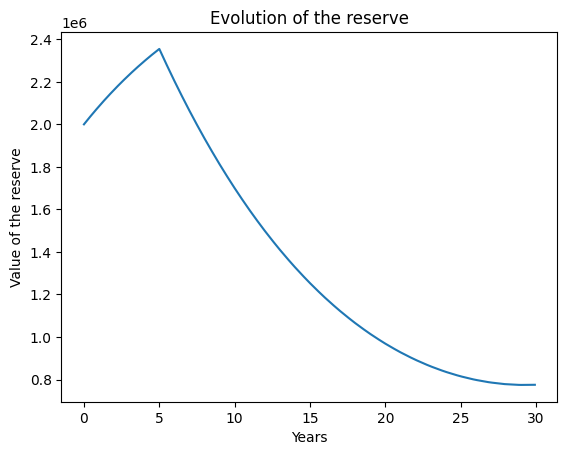

In [59]:
years = np.arange(0,T)/12
plt.plot(years,expectedGt);
plt.xlabel('Years')
plt.ylabel('Value of the reserve')
plt.title('Evolution of the reserve');

In [60]:
tableYears = ['0', '5', '10', '15', '20', '25', '30']
reserveDf = pd.DataFrame(columns = tableYears)
reserveDf.loc['Reserve'] = expectedGt[0], expectedGt[5*12-1], expectedGt[10*12-1], expectedGt[15*12-1], expectedGt[20*12-1], expectedGt[25*12-1], expectedGt[30*12-1]

print('                                   Reserve evolution over 30 years')
reserveDf

                                   Reserve evolution over 30 years


,0,5,10,15,20,25,30
Reserve,2000000.0,2.350056e+06,1.708832e+06,1.259138e+06,972132.548167,816560.634411,775347.178511
